# SETTING UP THE ENV

Lets impot Libraries

In [1]:
#download necessary libraries

!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.0 MB/s eta 0:00:0000:01


In [2]:
import sys
sys.path.append('/kaggle/working')
# !ls /kaggle/working
import torch
print(torch.__version__)
print(torch.version.cuda)

2.5.1+cu124
12.4


In [3]:
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, Size # Optional[Tensor], Union[Tensor, SparseTensor], Optional[Tuple[int, int]], all about data type

from torch import Tensor
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing

In [4]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import softmax
from sklearn.metrics import r2_score
from sklearn.neighbors import NearestNeighbors

# Pre Processing

In [5]:
df = pd.read_csv('/kaggle/input/cms-dataset/CMS_trigger.csv')
print(df.columns)

Index(['Unnamed: 0', 'Phi_0', 'Phi_2', 'Phi_3', 'Phi_4', 'Theta_0', 'Theta_2',
       'Theta_3', 'Theta_4', 'BendingAngle_0', 'BendingAngle_2',
       'BendingAngle_3', 'BendingAngle_4', 'TimeInfo_0', 'TimeInfo_2',
       'TimeInfo_3', 'TimeInfo_4', 'RingNumber_0', 'RingNumber_2',
       'RingNumber_3', 'RingNumber_4', 'Front_0', 'Front_2', 'Front_3',
       'Front_4', 'Mask_0', 'Mask_2', 'Mask_3', 'Mask_4',
       'PatternStraightness', 'Zone', 'MedianTheta', 'q/pt', 'PhiAngle',
       'EtaAngle'],
      dtype='object')


In [6]:
df.head()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_0,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle
0,0,58.066666,55.466667,55.466667,56.000000,11.970,11.684999,11.400,11.400,-13.000000,...,0.0,0.0,0.0,0.0,5.0,3.0,105.0,0.181209,-3.075936,1.722345
1,1,64.583336,66.800000,67.066666,67.200000,6.555,6.840000,6.555,6.840,7.000000,...,0.0,0.0,0.0,0.0,3.0,1.0,124.0,-0.146131,-0.167139,2.012122
2,2,71.150000,67.033330,66.266670,65.466670,2.850,2.565000,2.280,2.280,-16.613783,...,0.0,0.0,0.0,0.0,7.0,0.0,127.0,0.367024,2.431823,2.321646
3,3,34.933334,31.200000,31.200000,31.833334,9.690,8.835000,8.835,9.120,-13.000000,...,0.0,0.0,0.0,0.0,6.0,2.0,60.0,0.267774,-1.343305,1.854506
4,4,68.150000,68.266670,68.300000,68.400000,2.565,2.565000,2.565,2.565,0.000000,...,0.0,0.0,0.0,0.0,4.0,0.0,128.0,-0.019179,-3.134433,2.333772


In [7]:
df.describe()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_0,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle
count,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,...,1179356.0,1179356.0,1179356.0,1179356.0,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06
mean,5.896775e+05,4.851559e+01,4.851127e+01,4.851076e+01,4.851331e+01,6.195453e+00,5.918753e+00,5.848332e+00,5.881490e+00,5.603115e-02,...,0.0,0.0,0.0,0.0,3.976490e+00,1.080514e+00,9.115961e+01,5.540485e-04,8.881380e-04,8.762006e-04
std,3.404509e+05,1.774647e+01,1.779697e+01,1.781670e+01,1.779750e+01,3.011983e+00,2.921076e+00,2.911875e+00,2.906416e+00,1.493805e+01,...,0.0,0.0,0.0,0.0,1.871622e+00,1.089190e+00,3.328909e+01,2.524173e-01,1.820920e+00,2.075298e+00
min,0.000000e+00,1.103333e+01,2.400000e+00,2.666667e+00,2.666667e+00,1.425000e+00,1.425000e+00,1.425000e+00,1.710000e+00,-1.329103e+02,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,8.000000e+00,-4.999928e-01,-3.141584e+00,-2.499009e+00
25%,2.948388e+05,3.371667e+01,3.360000e+01,3.360000e+01,3.360000e+01,3.705000e+00,3.420000e+00,3.420000e+00,3.420000e+00,-1.100000e+01,...,0.0,0.0,0.0,0.0,3.000000e+00,0.000000e+00,6.300000e+01,-2.055347e-01,-1.584667e+00,-2.074832e+00
50%,5.896775e+05,4.830000e+01,4.826667e+01,4.826667e+01,4.826667e+01,5.700000e+00,5.415000e+00,5.415000e+00,5.415000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,4.000000e+00,1.000000e+00,9.100000e+01,2.155910e-04,8.142424e-03,1.523139e+00
75%,8.845162e+05,6.326667e+01,6.303333e+01,6.293333e+01,6.296667e+01,8.265000e+00,7.980000e+00,7.695000e+00,7.980000e+00,1.100000e+01,...,0.0,0.0,0.0,0.0,5.000000e+00,2.000000e+00,1.180000e+02,2.069167e-01,1.581958e+00,2.074729e+00
max,1.179355e+06,8.311667e+01,8.256667e+01,8.253333e+01,8.253333e+01,1.510500e+01,1.396500e+01,1.539000e+01,1.510500e+01,1.421401e+02,...,0.0,0.0,0.0,0.0,8.000000e+00,4.000000e+00,1.540000e+02,4.999991e-01,3.141592e+00,2.493834e+00


In [8]:
#HOW MOMENTUM NEGATIVE??

In [9]:
def set_deterministic(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(False)
    
set_deterministic(42)

**The data is not scaled, so we would have to scale the data first before we proceed to train a model on the data**

**To begin with lets  scale the data by using Standard Scalar**

In [10]:
scaler = StandardScaler()

In [11]:
df.shape

(1179356, 35)

In [12]:
df.loc[:,"pT"] = abs(1/df.loc[:,"q/pt"])

In [13]:
df['Theta_0'].max(), df['Theta_0'].min()

(15.105, 1.425)

In [14]:
import pandas as pd
import numpy as np

# Sample DataFrame (replace with your actual DataFrame loading code)
# df = pd.read_csv('your_file.csv')

# Convert DataFrame columns to NumPy arrays for computations
phi_0 = df['Phi_0'].values
phi_2 = df['Phi_2'].values
phi_3 = df['Phi_3'].values
phi_4 = df['Phi_4'].values

theta_0 = df['Theta_0'].values
theta_2 = df['Theta_2'].values
theta_3 = df['Theta_3'].values
theta_4 = df['Theta_4'].values

# Compute sine and cosine using NumPy
df['cos_Phi_0'] = np.cos(np.radians(phi_0))
df['cos_Phi_2'] = np.cos(np.radians(phi_2))
df['cos_Phi_3'] = np.cos(np.radians(phi_3))
df['cos_Phi_4'] = np.cos(np.radians(phi_4))

df['sin_Phi_0'] = np.sin(np.radians(phi_0))
df['sin_Phi_2'] = np.sin(np.radians(phi_2))
df['sin_Phi_3'] = np.sin(np.radians(phi_3))
df['sin_Phi_4'] = np.sin(np.radians(phi_4))

# Compute eta using NumPy
df['Eta_0'] = -np.log(np.tan(np.radians(theta_0 / 2)))
df['Eta_2'] = -np.log(np.tan(np.radians(theta_2 / 2)))
df['Eta_3'] = -np.log(np.tan(np.radians(theta_3 / 2)))
df['Eta_4'] = -np.log(np.tan(np.radians(theta_4 / 2)))



In [15]:
df.columns

Index(['Unnamed: 0', 'Phi_0', 'Phi_2', 'Phi_3', 'Phi_4', 'Theta_0', 'Theta_2',
       'Theta_3', 'Theta_4', 'BendingAngle_0', 'BendingAngle_2',
       'BendingAngle_3', 'BendingAngle_4', 'TimeInfo_0', 'TimeInfo_2',
       'TimeInfo_3', 'TimeInfo_4', 'RingNumber_0', 'RingNumber_2',
       'RingNumber_3', 'RingNumber_4', 'Front_0', 'Front_2', 'Front_3',
       'Front_4', 'Mask_0', 'Mask_2', 'Mask_3', 'Mask_4',
       'PatternStraightness', 'Zone', 'MedianTheta', 'q/pt', 'PhiAngle',
       'EtaAngle', 'pT', 'cos_Phi_0', 'cos_Phi_2', 'cos_Phi_3', 'cos_Phi_4',
       'sin_Phi_0', 'sin_Phi_2', 'sin_Phi_3', 'sin_Phi_4', 'Eta_0', 'Eta_2',
       'Eta_3', 'Eta_4'],
      dtype='object')

In [16]:
df.loc[:,"pT"].min()

2.00000380000722

In [17]:
label =df.loc[:,"pT"]

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = label.quantile(0.25)
Q3 = label.quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

In [18]:
# Define the acceptable range (1.5 times the IQR below Q1 and above Q3)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_df = df[(label >= lower_bound) & (label <= upper_bound)]
filtered_df = filtered_df.reset_index(drop=True)
# Extract the indices of the filtered dataset
filtered_indices = filtered_df.index.to_numpy()

# Split the filtered indices into training and test sets
train_idx, test_idx = train_test_split(filtered_indices, test_size=0.2, random_state=1)

In [19]:
selected_columns = [
    'sin_Phi_0', 'sin_Phi_2', 'sin_Phi_3', 'sin_Phi_4', 'cos_Phi_0', 'cos_Phi_2', 'cos_Phi_3', 'cos_Phi_4', 'Eta_0', 'Eta_2', 'Eta_3', 'Eta_4', 
    'BendingAngle_0', 'BendingAngle_2', 'BendingAngle_3', 'BendingAngle_4','pT'
]

# Select the columns from the DataFrame
filtered_df = filtered_df[selected_columns]

In [20]:
filtered_df.columns

Index(['sin_Phi_0', 'sin_Phi_2', 'sin_Phi_3', 'sin_Phi_4', 'cos_Phi_0',
       'cos_Phi_2', 'cos_Phi_3', 'cos_Phi_4', 'Eta_0', 'Eta_2', 'Eta_3',
       'Eta_4', 'BendingAngle_0', 'BendingAngle_2', 'BendingAngle_3',
       'BendingAngle_4', 'pT'],
      dtype='object')

In [21]:
filtered_df.loc[:,"sin_Phi_0":] = scaler.fit_transform(filtered_df.loc[:,"sin_Phi_0":])

**We can see that the std dev and the mean has been transformed to 1 and 0 respectively**

In [22]:
selected_features = ['sin_Phi_0', 'sin_Phi_2', 'sin_Phi_3', 'sin_Phi_4', 'cos_Phi_0',
       'cos_Phi_2', 'cos_Phi_3', 'cos_Phi_4', 'Eta_0', 'Eta_2', 'Eta_3',
       'Eta_4', 'BendingAngle_0', 'BendingAngle_2', 'BendingAngle_3',
       'BendingAngle_4']

In [23]:
# Extract features and labels
x_data = filtered_df[selected_features].to_numpy()
label = filtered_df['pT'].to_numpy()

# Ensure the shapes of x_data and label
assert x_data.shape[0] == label.shape[0], "Mismatch between x_data and label sizes"

# Print the new data shape and label shape
print('Data shape: ' + str(x_data.shape))
print(label.shape)
print('Len train: ' + str(len(train_idx)) + ', Len test: ' + str(len(test_idx)))
print('Num. features: ' + str(x_data.shape[-1]))

Data shape: (1029592, 16)
(1029592,)
Len train: 823673, Len test: 205919
Num. features: 16


# Dataset Class and Data Loaders

In [24]:
# x_data.shape

In [25]:
import itertools

In [26]:
import torch
import itertools
import numpy as np
from torch_geometric.data import Data

In [27]:
# Function to calculate eta from theta
def eta_from_theta(theta):
    return -np.log(np.tan(theta/2))

In [28]:
def connect_edges(sin_phi1, sin_phi2,  cos_phi1, cos_phi2, eta1, eta2):
    
    
    return [sin_phi2 - sin_phi1, 
                         cos_phi2 - cos_phi1, 
                         eta2 - eta1]

In [29]:
edge_index = []

# # Loop through each possible pair of nodes (i, j)
# for i in range(7):  # Nodes 0 to 6
#     for j in range(7):  # Nodes 0 to 6
#         if i != j:  # Avoid self-loops unless you want them
#             edge_index.append((i, j)) = []

# Loop through each possible pair of nodes (i, j)
for i in range(4):  # Nodes 0 to 6
    for j in range(4):  # Nodes 0 to 6
        if i != j:  # Avoid self-loops unless you want them
            edge_index.append((i, j))

In [30]:
edge_index

[(0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2)]

In [31]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data
import itertools

class Graph_dataset(Dataset):
    def __init__(self, dataset, label, edge_index, indices, transform=None):
        self.transform = transform
        self.data = dataset
        self.edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # Ensure correct shape
        self.indices = indices
        self.label = label
    
    def __getitem__(self, idx):
        return self.convert_to_graph(self.indices[idx])
    
    def __len__(self):
        return len(self.indices)
    
    def convert_to_graph(self, i):
        # Extract row data for the current index
        row = self.data.iloc[i]
        
        # Extract features
        sin_phi_values = torch.tensor(row[['sin_Phi_0', 'sin_Phi_2', 'sin_Phi_3', 'sin_Phi_4']].values, dtype=torch.float)
        cos_phi_values = torch.tensor(row[['cos_Phi_0', 'cos_Phi_2', 'cos_Phi_3', 'cos_Phi_4']].values, dtype=torch.float)
        eta_values = torch.tensor(row[['Eta_0', 'Eta_2', 'Eta_3', 'Eta_4']].values, dtype=torch.float)
        bend_angles = torch.tensor(row[['BendingAngle_0', 'BendingAngle_2', 'BendingAngle_3', 'BendingAngle_4']].values, dtype=torch.float)

        # Create node features (4 nodes, 1 feature per node)
        node_features = eta_values.unsqueeze(1)  # Add dimension for feature
  
        edge_features = []
        num_nodes = len(bend_angles)
        
        for k, j in itertools.permutations(range(num_nodes), 2):
            sin_phi1, cos_phi1, bending_1 = sin_phi_values[k].item(), cos_phi_values[k].item() ,  bend_angles[k].item()
            sin_phi2, cos_phi2, bending_2 = sin_phi_values[j].item(), cos_phi_values[j].item() ,  bend_angles[j].item()
            
            edge_feat = connect_edges(sin_phi1, sin_phi2,  cos_phi1, cos_phi2, bending_1, bending_2)
            edge_features.append(edge_feat)
        
        edge_features = torch.tensor(edge_features, dtype=torch.float)  # Ensure correct dtype and shape

        # Ensure edge_index and edge_attr have correct dimensions
        assert edge_features.size(1) == 3, "Edge features should have 3 dimensions"
        assert edge_features.size(0) == self.edge_index.size(1), "Number of edges should match edge features"
        
        # Create the graph data object
        data = Data(
            x=node_features, 
            edge_index=self.edge_index, 
            edge_attr=edge_features,
            y=torch.tensor(self.label[i], dtype=torch.float)
        )
        
        return data


In [32]:
train_idx

array([693515, 275177, 215047, ..., 470924, 491755, 128037])

In [33]:
train_dataset = Graph_dataset(filtered_df, label, edge_index, train_idx)
next(iter(train_dataset))

Data(x=[4, 1], edge_index=[2, 12], edge_attr=[12, 3], y=-0.6552883386611938)

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
import random

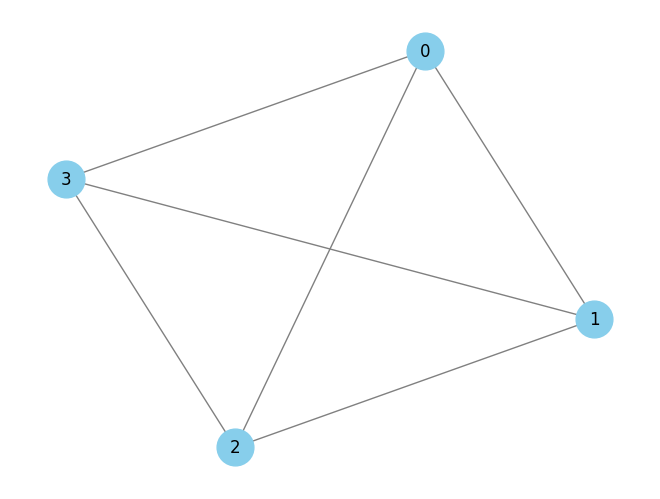

In [35]:
def plot_graph(data):
    G = nx.Graph()
    num_nodes = data.x.shape[0]
    G.add_nodes_from(range(num_nodes))
    edge_index = data.edge_index.numpy()
    edges = list(zip(edge_index[0], edge_index[1]))
    G.add_edges_from(edges)
    
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, edge_color='gray')
    plt.show()


for idx in [0]:
    graph_data = train_dataset[idx]
    plot_graph(graph_data)

**Yes we wanted the fully connected graph**

In [36]:
filtered_df

,sin_Phi_0,sin_Phi_2,sin_Phi_3,sin_Phi_4,cos_Phi_0,cos_Phi_2,cos_Phi_3,cos_Phi_4,Eta_0,Eta_2,Eta_3,Eta_4,BendingAngle_0,BendingAngle_2,BendingAngle_3,BendingAngle_4,pT
0,0.680653,0.556074,0.555731,0.581748,-0.463620,-0.294877,-0.294251,-0.328618,-1.540165,-1.586433,-1.561994,-1.558407,-0.830305,-0.015253,-0.008758,-0.005231,-0.063008
1,0.951025,1.026491,1.034475,1.039729,-0.903758,-1.056723,-1.074167,-1.084902,-0.357830,-0.538679,-0.482268,-0.555400,0.442012,-0.015253,-0.008758,-0.005231,0.273395
2,1.164943,1.034370,1.007226,0.979817,-1.372016,-1.073226,-1.017748,-0.962846,1.272358,1.374172,1.571878,1.594886,-1.060199,-3.537251,-0.008758,-0.005231,-0.772518
3,-0.687608,-0.952643,-0.950873,-0.906217,0.820094,0.975919,0.975256,0.950642,-1.124564,-1.038840,-1.064079,-1.119742,-0.830305,-0.015253,-0.008758,-0.005231,-0.516059
4,-0.738658,-0.599162,-0.597888,-0.608538,0.851419,0.765716,0.765267,0.771925,-1.444109,-1.488357,-1.512475,-1.558407,0.632859,-3.537251,-0.008758,-0.005231,0.368828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029587,-1.013943,-1.111523,-1.119560,-1.121619,1.006560,1.058255,1.062473,1.063405,-1.065926,-1.100947,-1.126031,-1.119742,-0.003299,-0.015253,-0.008758,-0.005231,0.678260
1029588,-0.379758,-0.328266,-0.318613,-0.310860,0.612301,0.575852,0.568985,0.562768,0.759120,0.813454,0.783597,0.801719,-0.003299,-0.015253,-0.008758,-0.005231,1.538815
1029589,0.985681,0.904515,0.884286,0.890092,-0.970105,-0.821941,-0.786507,-0.796631,-0.521241,-0.455574,-0.482268,-0.471989,-0.575842,-0.015253,-0.008758,-0.005231,0.002770
1029590,-0.255579,-0.302007,-0.312056,-0.310860,0.518401,0.555947,0.564015,0.562768,0.614119,0.657414,0.627945,0.645103,-0.355599,-0.015253,-0.008758,-0.005231,1.500156


In [37]:
train_loader = DataLoader(Graph_dataset(filtered_df, label, edge_index , train_idx), batch_size=1024)
test_loader = DataLoader(Graph_dataset(filtered_df, label, edge_index , test_idx), batch_size=1024)

In [38]:
next(iter(train_loader))

DataBatch(x=[4096, 1], edge_index=[2, 12288], edge_attr=[12288, 3], y=[1024], batch=[4096], ptr=[1025])

**We are all set with the dataset and the dataloader**

# Lets set the Model

In [39]:
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.utils import to_dense_batch
import torch
import torch.nn as nn
import torch.nn.functional as F

In [40]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, GlobalAttention

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import EdgeConv, GlobalAttention

class MODEL_GNN(torch.nn.Module):
    def __init__(self):
        super(MODEL_GNN, self).__init__()

        # Replace MPL with EdgeConv
        self.conv1 = EdgeConv(nn.Sequential(
            nn.Linear(2 * 1, 8),
            nn.ReLU(),
            nn.Linear(8, 8)
        ))

        self.conv2 = EdgeConv(nn.Sequential(
            nn.Linear(2 * 8, 12),
            nn.ReLU(),
            nn.Linear(12, 12)
        ))

        self.conv3 = EdgeConv(nn.Sequential(
            nn.Linear(2 * 12, 12),
            nn.ReLU(),
            nn.Linear(12, 12)
        ))

        self.conv4 = EdgeConv(nn.Sequential(
            nn.Linear(2 * 12, 16),
            nn.ReLU(),
            nn.Linear(16, 16)
        ))

        # Global attention pooling
        self.global_att_pool1 = GlobalAttention(nn.Sequential(nn.Linear(12, 1)))
        self.global_att_pool2 = GlobalAttention(nn.Sequential(nn.Linear(16, 1)))

        # MLP head
        self.lin1 = nn.Linear(28, 22)
        self.lin2 = nn.Linear(22, 16)
        self.lin3 = nn.Linear(16, 16)
        self.lin4 = nn.Linear(16, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x1 = self.global_att_pool1(x, batch)

        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x2 = self.global_att_pool2(x, batch)

        x_out = torch.cat([x1, x2], dim=1)
        x = F.relu(self.lin1(x_out))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = self.lin4(x).squeeze(1)

        return x

In [42]:
# Example usage:
# Initialize your model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MODEL_GNN().to(device)

In [43]:
model

MODEL_GNN(
  (conv1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
  ))
  (conv2): EdgeConv(nn=Sequential(
    (0): Linear(in_features=16, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=12, bias=True)
  ))
  (conv3): EdgeConv(nn=Sequential(
    (0): Linear(in_features=24, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=12, bias=True)
  ))
  (conv4): EdgeConv(nn=Sequential(
    (0): Linear(in_features=24, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  ))
  (global_att_pool1): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=12, out_features=1, bias=True)
  ), nn=None)
  (global_att_pool2): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  ), nn=None)
  (lin1): Linear(in_feature

In [44]:
total_params = sum(p.numel() for p in model.parameters())
learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total number of parameters: {total_params}")
print(f"Number of learnable parameters: {learnable_params}")

Total number of parameters: 2909
Number of learnable parameters: 2909


In [45]:
model

MODEL_GNN(
  (conv1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
  ))
  (conv2): EdgeConv(nn=Sequential(
    (0): Linear(in_features=16, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=12, bias=True)
  ))
  (conv3): EdgeConv(nn=Sequential(
    (0): Linear(in_features=24, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=12, bias=True)
  ))
  (conv4): EdgeConv(nn=Sequential(
    (0): Linear(in_features=24, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  ))
  (global_att_pool1): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=12, out_features=1, bias=True)
  ), nn=None)
  (global_att_pool2): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  ), nn=None)
  (lin1): Linear(in_feature

In [46]:
train_dataset[20]

Data(x=[4, 1], edge_index=[2, 12], edge_attr=[12, 3], y=2.224287271499634)

In [47]:
data = train_dataset[20]  # Get the data instance
x = data.x  # Node features: shape [4, 1]
edge_index = data.edge_index  # Edge indices: shape [2, 12]
edge_attr = data.edge_attr  # Edge attributes: shape [12, 3]
batch = torch.zeros(x.size(0), dtype=torch.long) 

In [48]:
# Forward pass with input data x and edge_index

In [49]:
# Define the MSE loss function
import torch.nn as nn
criterion = nn.MSELoss()

In [50]:
import torch
import os

def save_checkpoint(model, optimizer, scheduler, epoch, min_test_loss, model_name):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'min_test_loss': min_test_loss
    }
    torch.save(checkpoint, model_name)
    print(f"Checkpoint saved at epoch {epoch}.")

def load_checkpoint(model, optimizer, scheduler, model_name):
    checkpoint = torch.load(model_name)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    min_test_loss = checkpoint['min_test_loss']
    print(f"Resuming from checkpoint at epoch {epoch}, with minimum test loss {min_test_loss}.")
    return epoch, min_test_loss


In [51]:
def train(train_loader, test_loader, prog_bar = True):
    
    train_losses, test_losses = list(), list()
    min_test_loss = float('inf')
#     criterion = nn.MSELoss()
    for epoch in range(epochs):
        train_loss = 0
        test_loss = 0
        if prog_bar:
            pbar = tqdm(train_loader,position=0)
        else:
            pbar = train_loader
            
        # train
        for data in pbar:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            labels = data.y
            loss = CustompTLoss(out, data.y,min_PT)
            loss.backward()
            optimizer.step()
            if prog_bar:
                pbar.set_description('pTLoss: '+str(loss.cpu().detach().numpy()))
                train_loss += loss.cpu().detach().numpy()/len(train_loader)
                
        # test
        for data in test_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            labels = data.y
            loss = CustompTLoss(out, data.y,min_PT)
            test_loss += loss.cpu().detach().numpy()/len(test_loader)
        if test_loss<min_test_loss:
            print('Min loss changed from '+str(min_test_loss)+' to '+str(test_loss))
            min_test_loss = test_loss
            torch.save(model.state_dict(), model_name)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if epoch > 10 and min(test_losses[-7:])>min_test_loss+1e-9:
            break
        lr_scheduler.step(test_loss)
        print('Epoch: ', str(epoch+1)+'/'+str(epochs),'| Training Loss: ', train_loss, '| Testing Loss: ', test_loss)
        
        if prog_bar and (epoch%5==0):
            plt.plot(train_losses, label="Train Loss")
            plt.plot(test_losses, label="Validation Loss")
            plt.xlabel("# Epoch")
            plt.ylabel("Loss")
            plt.legend(loc='upper right')
            plt.show()
    return train_losses, test_losses

In [52]:
def pTLossTorch(y_pred,y_true):
#     if not inv:
#         y_pred = torch.pow(y_pred,-1)
#         y_true = torch.pow(y_true,-1)
    y_t = (y_true<80).type(torch.FloatTensor)*y_true.type(torch.FloatTensor) + (y_true>=80).type(torch.FloatTensor)*(y_true<250).type(torch.FloatTensor)*y_true.type(torch.FloatTensor)**2.4 + (y_true>=160).type(torch.FloatTensor)*10 
    return torch.mean(y_t.type(torch.FloatTensor)*torch.pow((y_pred-y_true)/y_true,2).type(torch.FloatTensor))/250

def CustompTLoss(output, target, lower_pt_limit):
    
    if not isinstance(lower_pt_limit, torch.Tensor):
        lower_pt_limit = torch.tensor(lower_pt_limit)
    
    lower_pt_limit = lower_pt_limit.to(output.dtype)
    output =torch.clip(output, min=lower_pt_limit.to(device))
    loss = torch.mean((target - output)**2 + torch.gt(output, lower_pt_limit.long() * \
        (1 / (1 + torch.exp(-(output - lower_pt_limit) * 3)) - 1) + \
            torch.le(output, lower_pt_limit).long()*(-1/2)))
    return loss



In [53]:
name =  f"CONVERTED_graph"

In [54]:
min_PT = label.min()
max_pT = label.max()

  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from inf to 1.9939979297099732
Epoch:  1/5 | Training Loss:  1.4796348927924363 | Testing Loss:  1.9939979297099732


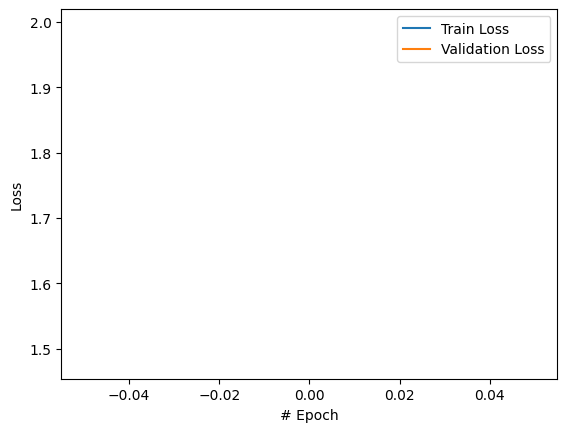

  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 1.9939979297099732 to 1.9939958742349464
Epoch:  2/5 | Training Loss:  1.5257114300076273 | Testing Loss:  1.9939958742349464


  0%|          | 0/805 [00:00<?, ?it/s]

Epoch:  3/5 | Training Loss:  1.5306699445529008 | Testing Loss:  1.9939992115049079


  0%|          | 0/805 [00:00<?, ?it/s]

Epoch:  4/5 | Training Loss:  1.5616896103627924 | Testing Loss:  1.9940413395957184


  0%|          | 0/805 [00:00<?, ?it/s]

Epoch:  5/5 | Training Loss:  1.572869395099073 | Testing Loss:  1.9940424325442554


In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 50
model = MODEL_GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=1, factor=0.5)

model_name = f'/kaggle/working/model_trained/{name}_loss' + 'no_inv_' + '.pth'
os.makedirs("/kaggle/working/model_trained" , exist_ok =True)
train_losses, test_losses = train(train_loader, test_loader, prog_bar=True)

# TESTING

## Metrics

In [56]:
def f1_comp(y_true,y_pred):
    f1 = []
    for i in range(100): 
        grnd = y_true >= i
        pred = y_pred >= i
        f1.append(sklearn.metrics.f1_score(grnd,pred))
    return f1

def acc_comp(y_true,y_pred):
    acc = []
    for i in range(100):
        grnd = y_true >= i
        pred = y_pred >= i
        cmp = np.sum(np.equal(grnd,np.squeeze(pred))) 
        acc.append(cmp/len(grnd)*100)
    return acc

In [57]:
# model_name = f'/kaggle/working/model_trained/{name}_loss' + 'no_inv_' + '.pth'
# model_name = "/kaggle/input/eachstation-node-v2/model_trained/CONVERTED_graph_lossno_inv_A2.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model = MODEL_GNN().to(device)
loaded_model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [58]:
import numpy as np
import sklearn.metrics
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

In [59]:
import time
import numpy as np
import torch
from tqdm import tqdm
import sklearn.metrics



y_true_all = []
y_pred_all = []
test_los = 0
loaded_model.eval()

# Start GPU timer
start_gpu_time = torch.cuda.Event(enable_timing=True)
end_gpu_time = torch.cuda.Event(enable_timing=True)

start_gpu_time.record()

with torch.no_grad():
    for data in tqdm(test_loader, position=0):
#         print(data)
        data = data.to(device)
        out = loaded_model(data)

        # Collect true labels and predictions
        labels = data.y.cpu().numpy()
        y_true_all.extend(labels)
        y_pred_all.extend(out.cpu().detach().numpy())

        loss = criterion(out, data.y)
        test_los += loss.cpu().detach().numpy() / len(test_loader)

# End GPU timer
end_gpu_time.record()

# Waits for everything to finish running on the GPU
torch.cuda.synchronize()

# Calculate total GPU inference time
total_gpu_inference_time = start_gpu_time.elapsed_time(end_gpu_time) / 1000.0  # Convert to seconds
print(f"Total GPU inference time: {total_gpu_inference_time:.6f} seconds")

# Convert collected labels and predictions to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Apply scaling to the predictions
y_true_all = y_true_all * scaler.scale_[-1] + scaler.mean_[-1]
y_pred_all = y_pred_all * scaler.scale_[-1] + scaler.mean_[-1]

# Calculate F1 scores and accuracy
f1_scores = f1_comp(y_true_all, y_pred_all)
accuracy_scores = acc_comp(y_true_all, y_pred_all)

# Calculate MAE
mae = sklearn.metrics.mean_absolute_error(y_true_all, y_pred_all)
mse = sklearn.metrics.mean_squared_error(y_true_all, y_pred_all)

print(f"MAE: {mae:.6f}")
print(f"MSE: {mse:.6f}")

100%|██████████| 202/202 [04:53<00:00,  1.45s/it]


Total GPU inference time: 293.534250 seconds
MAE: 2.989572
MSE: 15.410899


In [60]:
# Print results
print('Test_loss:', test_los)
print("F1 Scores:", f1_scores[-1])
print("Accuracy Scores:", accuracy_scores[-1])
print("Mean Absolute Error (MAE):", mae)

Test_loss: 0.9939958621369732
F1 Scores: 0.0
Accuracy Scores: 100.0
Mean Absolute Error (MAE): 2.9895723


In [61]:
import csv

# Data to be saved
results = {
    'Test_loss': test_los,
    'F1_Score': f1_scores[-1],
    'Accuracy_Score': accuracy_scores[-1],
    'MAE': mae
}

# Save to CSV
with open('evaluation_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Metric', 'Value'])
    for key, value in results.items():
        writer.writerow([key, value])

print('Results saved to evaluation_results.csv')

Results saved to evaluation_results.csv


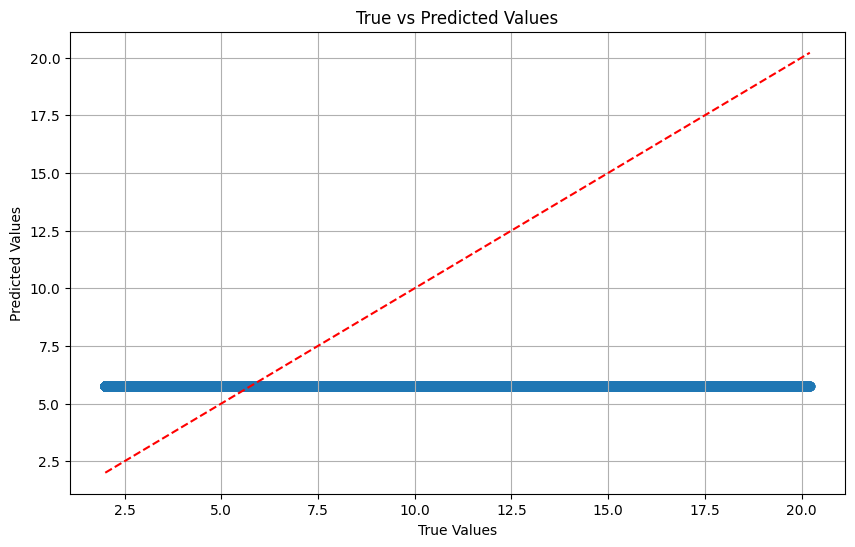

In [62]:
import matplotlib.pyplot as plt

# Assuming y_true_all and y_pred_all are defined and properly inverted

plt.figure(figsize=(10, 6))
plt.scatter(y_true_all, y_pred_all, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.plot([min(y_true_all), max(y_true_all)], [min(y_true_all), max(y_true_all)], color='red', linestyle='--') # Line of equality
plt.grid(True)
plt.show()


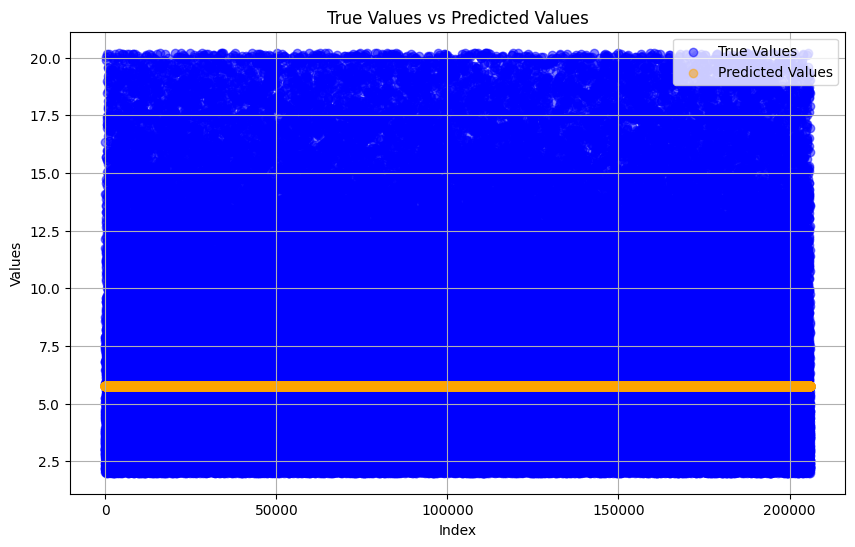

In [63]:
import matplotlib.pyplot as plt

# Example data for y_true_all and y_pred_all
# y_true_all = [your data here]
# y_pred_all = [your data here]

plt.figure(figsize=(10, 6))

# Plotting the true values
plt.scatter(range(len(y_true_all)), y_true_all, color='blue', alpha=0.5, label='True Values')

# Plotting the predicted values
plt.scatter(range(len(y_pred_all)), y_pred_all, color='orange', alpha=0.5, label='Predicted Values')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('True Values vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


In [64]:
from scipy.stats import norm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import plotly.graph_objects as go
from scipy.optimize import curve_fit

In [65]:
def cuts(datain,datacheck,minval,maxval):
    dataout = datain[np.logical_and(datacheck > minval, datacheck < maxval)]
    
    return(dataout)

In [66]:
def plotgaussian(modelname, modelorreco, space, true, pred, varname, lower, upper, bins):
    resmeans = []
    stdevs = []
    bincenters = []
    samples = []
    
    #Compute residuals and bin width
    width = (upper - lower) / bins
    true = cuts(true, pred, lower, upper)
    pred = cuts(pred, pred, lower, upper)
    pred = cuts(pred, true, lower, upper)
    true = cuts(true, true, lower, upper)
    
    resids = true - pred
    
    #Create gaussian plot for each bin
    for i in range(bins):
        #Find bin dimensions
        lowertemp = lower + width * i
        uppertemp = lower + width * (i + 1)
        bincentertemp = (uppertemp + lowertemp) / 2
        
        #Cut the residuals to within lower and upper range along true values
        residscut = cuts(resids, 
                         true, 
                         lowertemp, 
                         uppertemp)
        
        varnametemp = '%s Residuals Distribution (%.2f to %.2f)' % (varname, 
                                                                    lowertemp, 
                                                                    uppertemp)
        residscut.sort()
        
        #Computer statistics for residuals
        resmeantemp, resstdtemp = norm.fit(residscut)
        samplestemp = len(residscut)
        pdf = stats.norm.pdf(residscut, resmeantemp, resstdtemp)
        
        #Plot histogram of residuals
        plt.hist(residscut, 
                 bins=bins, 
                 histtype='step', 
                 color='blue', 
                 density=1, 
                 label='Residuals')
        
        #Plot the normal curve fitted to the residuals
        plt.plot(residscut, 
                 pdf, 
                 label='Normal Curve', 
                 color='black')
        plt.title(varnametemp)
        
        #Plot the residuals mean as a vertical line
        plt.axvline(resmeantemp, 
                    label='Mean: %.2f' % resmeantemp, 
                    color='red')
        plt.xlabel('Stdev: %.2f (samples: %.i)' % (resstdtemp, 
                                                   samplestemp))
        
        #Plot the full-width half maximum range
        plt.axvspan(resmeantemp - resstdtemp / 2,
                    resmeantemp + resstdtemp / 2,
                    facecolor='g',
                    alpha=.3,
                    label='Stdev')        
        plt.legend()
        plt.savefig(f"{space}_gaussian.png", bbox_inches='tight')
        plt.close()
        
        #Append values to lists to be used by scatter() function
        resmeans.append(resmeantemp)
        samples.append(samplestemp)
        stdevs.append(resstdtemp)
        bincenters.append(bincentertemp)
    
    resmean = np.mean(resids)
    stddev = np.std(resids)    
    
    return resmeans, stdevs, bincenters, samples, resmean, stddev

In [67]:
resmeans, fwhms, bincenters, samples, resmean, stddev = \
    plotgaussian(model_name, 
                 'Model', 
                 "/kaggle/working/", 
                 y_true_all, 
                 y_pred_all, 
                 'pT', 
                 min_PT, 
                 max_pT, 
                 100)

In [68]:
def heatmap(modelname, modelorreco, space, true, pred, varname, lower, upper, bins):
    #Get histogram dimensions and data using numpy
    heatmap, xedges, yedges = np.histogram2d(true, 
                                             pred, 
                                             bins=bins, 
                                             range=[[lower, upper], [lower, upper]])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    #Plot heatmap
    plt.imshow(heatmap.T, 
               extent=extent, 
               origin='lower')
    plt.plot([lower, upper], 
             [lower, upper], 
             color='blue')
    fig = plt.gcf()
    plt.set_cmap('gist_heat_r')
    plt.xlabel('%s True' % varname)
    plt.ylabel('%s Pred' % varname)
    plt.title('Frequency Heatmap')
    plt.xlim(lower, upper)
    plt.ylim(lower, upper)
    plt.colorbar()
    fig.savefig(f"{space}_heatmap.png")
    plt.plot()
    plt.close()

In [69]:
heatmap(model_name, 
            'Model', 
            "/kaggle/working/", 
            y_true_all, 
            y_pred_all, 
            'pT', 
            min_PT, 
            12, 
            50)

In [70]:
def scatter(modelname, space, metrics, bincenters, samples, varname, prednames, metricname):
    bincenters = np.array(bincenters)
    #Check that the bin centers match between the two datasets
    if (np.std(bincenters[:,0]) > .0001) or (np.std(bincenters[:,-1]) > .0001):
        print('Scatter plot failed due to different bincenters')
        print(bincenters)
        return
    else:
        #Create subplots for scatter and ratio
        fig,axs = plt.subplots(2, gridspec_kw={'height_ratios':[3,1]})
        axs[0].set_ylabel(metricname)
        axs[0].set_title('Residuals %s vs %s' % (metricname,
                                                varname))
        
        for i in range(len(prednames)):
            #Find the width and range of bins
            width = (bincenters[i][-1] - bincenters[i][-2]) / 2
            lower = min(bincenters[i]) - width
            upper = max(bincenters[i]) + width        

#             if i == 0:
#                   dif1 = np.abs(metrics[i])
#             elif i == 1:
#                   dif2 = np.abs(metrics[i])
                    
            if i == 0:
                  metric1 = np.array(metrics[i])
            elif i == 1:
                  metric2 = np.array(metrics[i])

            print(np.shape(metrics))
            #Create the scatterplot
            axs[0].scatter(bincenters[i], 
                           metrics[i], 
                           label=prednames[i])
            axs[0].axhline(y=0)


            #Use standard error of the mean for y error and bin width for x error
            axs[0].errorbar(bincenters[i],
                            metrics[i],
                            xerr=(bincenters[i][-1] - bincenters[i][-2]) / 2,
                            yerr=metrics[i] / np.sqrt(samples[i]),
                            linestyle='')
        axs[0].legend()
        axs[0].set_xlim([lower,upper])
        
#         dif = dif1 - dif2
#         #Create ratio subplot
#         axs[1].scatter(bincenters[0], dif)
#         axs[1].axhline(y=0)
#         axs[1].set_xlim([lower, upper])
#         axs[1].set_ylabel('|%s| - |%s|' % (prednames[0], prednames[1]))
#         axs[1].set_xlabel('%s' % varname)
        
        #Plot ratio subplot for first 2 data sets
        axs[1].scatter(bincenters[i], metric1 / metric2)
        axs[1].axhline(y=1)
        axs[1].set_xlim([lower,upper])
        axs[1].set_ylim([0.5,2.0])
        axs[1].set_yscale('log', basey=2)
        axs[1].set_ylabel('%s / %s' % (prednames[0],
                                       prednames[1]))
        axs[1].set_xlabel('%s' % varname)
        
        #Save plot
        fig.savefig('./Plots/%s/Comparison/%s/%s_%s_scatter' % (modelname, 
                                                                space,
                                                                varname,
                                                                metricname), bbox_inches='tight')
        plt.close()

In [71]:
from torch.profiler import profile, record_function, ProfilerActivity
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
     

def profile_model(model, inputs, num_runs=100):
    total_time = 0
    for _ in range(num_runs):
        with profile(activities=[ProfilerActivity.CUDA], record_shapes=True) as prof:
            model(inputs)

        # Extract total CUDA time spent on 'model_inference'
        for event in prof.key_averages():
            total_time += event.cuda_time_total

    average_time = total_time / num_runs
    print(f"Average inference time: {average_time} microseconds")
     
# test_loader_2 = DataLoader(Graph_dataset(filtered_df, label, edge_index , test_idx), batch_size=1)
# inputs = next(iter(test_loader_2))
# inputs = inputs.to(device)
inputs = train_dataset[20].to(device)
# model = ...
# profile_model(loaded_model, inputs, 1000)

In [72]:
# next(iter(Graph_dataset))

In [73]:
# test_loader_2 = DataLoader(Graph_dataset(filtered_df, label, edge_index , test_idx), batch_size=1)

In [74]:
from torch.profiler import profile, record_function, ProfilerActivity
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
     

def profile_model(model, inputs, num_runs=100):
    total_time = 0
    for _ in range(num_runs):
        with profile(activities=[ProfilerActivity.CUDA], record_shapes=True) as prof:
            model(inputs)

        # Extract total CUDA time spent on 'model_inference'
        for event in prof.key_averages():
            total_time += event.cuda_time_total

    average_time = total_time / num_runs
    print(f"Average inference time: {average_time} microseconds")
     
# test_loader_2 = DataLoader(Graph_dataset(filtered_df, label, edge_index , test_idx), batch_size=1)
# inputs = next(iter(test_loader_2))
# inputs = inputs.to(device)
inputs = train_dataset[20].to(device)
# model = ...
profile_model(loaded_model, inputs, 1000)

AttributeError: 'FunctionEventAvg' object has no attribute 'cuda_time_total'